In [1]:
%matplotlib inline

from __future__ import division
import os
import sys
from scipy import integrate, optimize
from scipy.interpolate import interp2d, interp1d

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P
from time import clock


matplotlib.rcParams['figure.figsize'] = (7, 5)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=18) 
P.rc('ytick', labelsize=18)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


# sys.path.append("/Users/amadeus/Documents/10.semester/ma")
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21, h
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, T_obs, nutoz21, h
from magmod import *
from magbias_experiments import SKA, CLAR, n


sigma_8_BBKS = 0.833959881058


In [2]:
# #preliminary, to be changed!!
# bHI = 1
# bgal = 1

lmin = 250; lmax = 30000 # lmin and lmax for Cl calculation
# lmin = 1; lmax = 1000 # lmin and lmax for Cl calculation
# ltab = np.arange(lmin,lmax)
# ltab = np.arange(lmin,lmax, 1000)
ltab = np.logspace(np.log10(lmin), np.log10(lmax), 25, dtype = int)
# ltab = np.array([280])

################################################
# ZhangPen:
zf = 0.75
dzf = 0.25
zfmin = zf - dzf; zfmax = zf + dzf

zb = (1.5 + 1.9)/2
dzb = 1.9 - zb
zbmin = zb - dzb; zbmax = zb + dzb
################################################



# ################################################
# zf = 0.3
# dzf = 0.005
# zfmin = zf - dzf; zfmax = zf + dzf

# zb = 1.5
# dzb = 0.01
# zbmin = zb - dzb; zbmax = zb + dzb
# ################################################



# zf = .1
# dzf = 0.06
# zfmin = zf - dzf; zfmax = zf + dzf

# zb = .4
# dzb = 0.06
# zbmin = zb - dzb; zbmax = zb + dzb

print "foreground from {} to {}".format(zfmin, zfmax)
print "background from {} to {}".format(zbmin, zbmax)



foreground from 0.5 to 1.0
background from 1.5 to 1.9


From ZiourHui:

In [3]:
#two ways to compute the same thing:




def Cl_delkap2_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = bHI * (5*sg(zb) - 2)
    return Cl_HIxmag_CAMB(ltable, zf, zb, delta_zf, Nint = Nint) / fac

def Cl_delkap_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = 3/2 * (H_0/c)**2 * Omega_m
    
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
#     gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    gtab = g(ztab, zb, dzb)
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= [(1+zzz) * W_tophat(zzz, zfmin, zfmax) * gtab / rCom(zzz)**2 * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab]
    result= fac * np.trapz(integrand,ztab,axis=0)
    return result

Now we reproduce Fig 1 and 2 successfully (just adjust survey area and experiment accordingly):

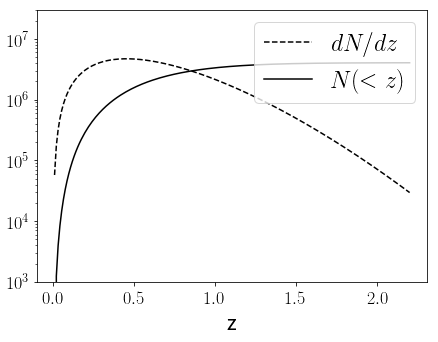

In [4]:
ztab = np.linspace(0.01, 2.2,200)
nsig=4
Flux = n * Ssys(ztab, CLAR) #we require an n-sigma detection


dNdztab = dNdz(ztab, nsig, CLAR)
Ntab = N_HI(ztab, nsig, CLAR)

fig = P.figure(); ax = fig.add_subplot(111);
ax.semilogy(ztab, dNdztab, ls = "--", color = "black", label = r"$dN/dz$" )
ax.semilogy(ztab, Ntab, color = "black", label = r"$N(<z)$")

ax.set_ylim((1e3, 3e7))
ax.set_xlabel("z")

P.legend(loc = "upper right")



We were not able to calculate $\alpha$ as in the zhang&pen paper, so we simply fit a curve to their figures. 


From arXiv:0706.1071 equation A9: $s = \frac{d\log_{10} n_g}{dm}$ with the magnitude threshold $m = -2.5 \log_{10} F$. Therefore we have $s = -\frac{5}{2} \frac{d\log_{10} n_g}{d\log_{10}F} = \frac{5}{2} \alpha$

Thus we can also use the $s_g$ we used for Alkistis HIxmag Cls to get $\alpha$.

To test, we plot our fit for $\alpha$:

Caution, s_g is implemented without dependence on the experiment


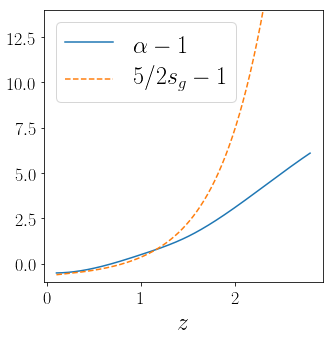

In [5]:
#now plot s :

z = np.linspace(0.1, 2.8, 500)

Ftab = nsig * Ssys(z, CLAR)
mtab = -2.5 * np.log10(Ftab)

fig = P.figure(figsize = (5,5));
ax2 = fig.add_subplot(111)


ax2.plot(z, alpha(z, CLAR)-1, label = r"$\alpha-1$")
ax2.plot(z, 5/2*sg(z)-1, label = r"$5/2 s_g-1$", ls = "--")

ax2.set_xlabel(r"$z$")
ax2.set_ylim((-1, 14))


P.legend()

The rest of this notebook is plotting the stuff from Alkistis' notes which seems to work (comparable to fig 5). First I have to get $\alpha$ right before I can compare to the quantities from Zhang&Pen directly.

In [6]:
#Calculate the HI X mag power spectrum Cls:
Cl_Hxm_tab = Cl_HIxmag_CAMB(ltab, zf, dzf, zb, dzb)
Cl_gxm_tab = Cl_gxmag_CAMB(ltab, zf, dzf, zb, dzb, n, CLAR)


Caution, s_g is implemented without dependence on the experiment


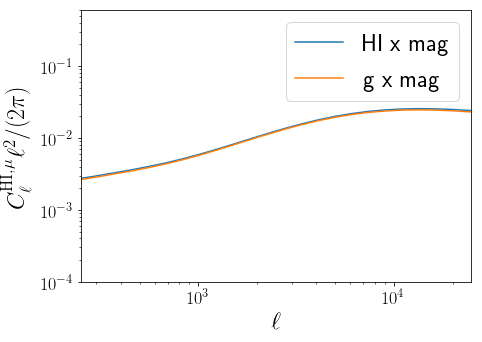

In [11]:
#plot it:
fig = P.figure(); ax = fig.add_subplot(111);

ax.loglog(ltab, Cl_Hxm_tab*ltab**2 / 2 / pi, label = "HI x mag")
ax.loglog(ltab, Cl_gxm_tab*ltab**2 /2/ pi, label = "g x mag")

ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell^\mathrm{HI, \mu} \ell^2/(2\pi)$")

ax.set_xlim((250,25000))
ax.set_ylim((1e-4, 6e-1))
ax.legend()


I think our $C_\ell^\mathrm{HI, mag}$ should match $C_\ell^{\mu g}$ Fig. 5 in Zhang&Pen up to a constant factor, which it does! It matches even better than trying to reproduce it directly...

The main difference in the calculations is that Alkistis takes $s_g$ out of the integral, whereas in Z&P it's inside. It evolves a lot with redshift so I would expect that to be significant.

[Their $\ell$ dependece is $C_\ell^{\mu g} \sim \Delta_m^2(\ell/r(z_f), z_f) / l^3$.

For us it's $C_\ell^\mathrm{HI, mag} \sim P((\ell + 1/2)/r(z),z))$.]

Next step: get error on gxmag

NOW: signal to noise for perfect survey:

In [30]:
##making new zf:
# zfs = np.linspace(0.8,zb - 2*dzb,5)
# dzf = 0.05

#using the same one as above:
zfs = np.array([zf])

lstart = 10; lend = 20000; lN = 50
# ltab = np.linspace(lstart, lend, lN, dtype = int)
ltab = np.logspace(np.log10(lstart), np.log10(lend), lN, dtype = int)
powspeclist = [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB]
S2N_p_tab = []
Delta_Cl_p_tab = []
for zzf in zfs:
    print "foreground from {} to {}".format(zzf-dzf, zzf+dzf)

    S2N_p_tab.append( S2N(ltab, zzf, dzf, zb, dzb, powspeclist, SURVEY="CV") )
#     Delta_Cl_p_tab.append( DELTA_Cl_HIxmag(ltab, zzf, dzf, zb, dzb, PERFECT_SURVEY=1))
    
print "background from {} to {}".format(zb-dzb, zb+dzb)


foreground from 0.5 to 1.0
Caution, s_g is implemented without dependence on the experiment
Caution, s_g is implemented without dependence on the experiment
background from 1.5 to 1.9


In [31]:
# S2Narr = np.array(S2N_p_tab)

# fig = P.figure(); ax = fig.add_subplot(111);

# ax.plot(zfs, S2Narr[:,0], label = "l = {}".format(ltab[0]))
# ax.plot(zfs, S2Narr[:,10], label = "l = {}".format(ltab[10]))
# ax.plot(zfs, S2Narr[:,19], label = "l = {}".format(ltab[19]))


# ax.set_xlabel("$z_f$")
# ax.set_ylabel("S2N")
# P.legend()


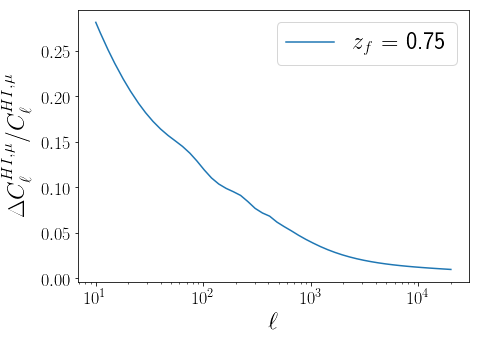

In [32]:
#plot DeltaCl / Cl:

fig = P.figure(); ax1 = fig.add_subplot(111); 

for i in range(len(S2N_p_tab)):
    ax1.semilogx(ltab, 1/S2N_p_tab[i], label = "$z_f$ = {}".format(np.around(zfs[i],2)))

ax1.set_ylabel("$\Delta C_\ell^{HI,\mu} / C_\ell^{HI,\mu}$")
ax1.set_xlabel("$\ell$")
ax1.legend()


# This is very low, but it's for a perfect survey. Let's now implement shot and white noise, fsky, and the $\ell$ binning and set the boolean 'perfect_survey' to False!